In [1]:
import pystac_client
from odc import stac as odc_stac
from dask.distributed import wait
from dask.distributed import Client, wait
import xarray as xr
import pyproj
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import rioxarray
import hvplot.xarray
import hvplot.pandas
import geopandas as gpd
from rasterio import features
from rasterio.enums import Resampling
from shapely.geometry import shape
from shapely.geometry import Polygon, MultiPolygon,LinearRing
from shapely.ops import unary_union
import geoviews as gv
from dcloader import DcLoader
from preprocessing import DataPreprocessor

In [2]:
# set up dask client for paralelized computation
client = Client(processes=False, threads_per_worker=2, n_workers=3, memory_limit="12GB")

# Connect to STAC catalog
eodc_catalog = pystac_client.Client.open("https://stac.eodc.eu/api/v1/")

In [3]:
# we define the time range of the event and coordinates of the area with the bounding_box
time_range = "2018-02-28/2018-02-28"
minlon, maxlon = 22.0, 22.8  
minlat, maxlat = 39.45, 39.75

bounding_box = [minlon, minlat, maxlon, maxlat]

dc_loader = DcLoader(eodc_catalog)

greece_dc = dc_loader.load_GFM_data(time_range, bounding_box)

Persisting data cube to Dask cluster...
Data loaded successfully.


In [4]:
processor =  DataPreprocessor(greece_dc)

In [5]:
#clean tuw data
greece_dc["tuw_flood_extent"] = processor.clean_flood_band("tuw_flood_extent")
greece_dc["tuw_likelihood"] = processor.clean_flood_band("tuw_likelihood")

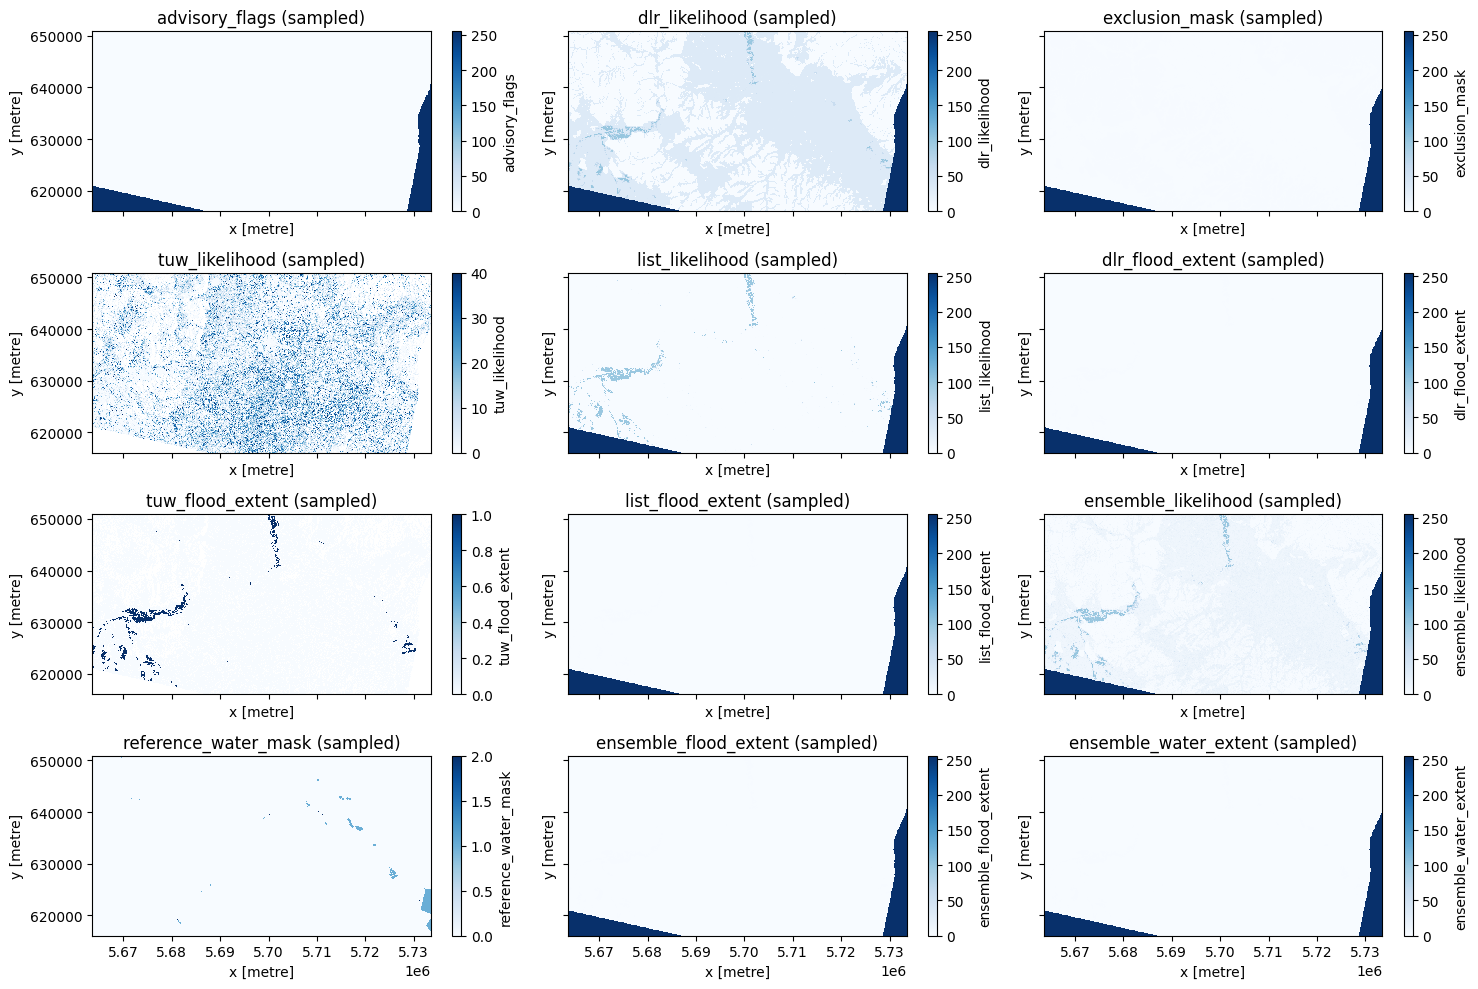

In [6]:
# Option 1: Sample every nth pixel for faster plotting
fig, ax = plt.subplots(4, 3, figsize=(15, 10), sharey=True, sharex=True)
band_names = list(greece_dc.data_vars.keys())  # First 3 bands only

for i, band_name in enumerate(band_names):
    sampled_data = greece_dc[band_name][1, ::4, ::4]
    col = i % 3
    row = i // 3
    sampled_data.plot(ax=ax[row, col], cmap='Blues')
    ax[row, col].set_title(f'{band_name} (sampled)')

plt.tight_layout()
plt.show()

In [7]:
zw1 = greece_dc

In [ ]:
greece_dc["tuw_flood_extent"]  = processor.limit_time_Of_band("tuw_flood_extent",1)
greece_dc["tuw_likelihood"] = processor.limit_time_Of_band("tuw_likelihood",1)

In [12]:
def clip_to_bbox(da, bbox):
        minlon, maxlon, minlat, maxlat = bbox
        return da.rio.clip_box(minx=minlon, maxx=maxlon, miny=minlat, maxy=maxlat)

In [13]:
def reproject_band(band, bbox ):
        """
        Reproject bands to WGS84 (lon/lat)

        Args:
            band (str): The name of the band to clean.

        Returns:
            xarray.DataArray: Cleaned band DataArray.
        """
        crs = band.rio.crs
        ae_crs  =crs.to_proj4()

        da = band.rio.write_crs(ae_crs)

        da = da.rio.reproject("EPSG:4326")

        da = clip_to_bbox(da, bbox)

        return da

In [14]:

da_ll_clipped = reproject_band(greece_dc["tuw_flood_extent"] ,bounding_box)


da_visible = da_ll_clipped.where(da_ll_clipped == 1)
da_visible.hvplot.image(
    x="x", y="y",
    geo=True,
    tiles="OSM",
    cmap=["darkred"],
    alpha=0.75,
    frame_height=450,
    title="Flood Extent on Map",
    colorbar=False
)

:Overlay
   .WMTS.I  :WMTS   [Longitude,Latitude]
   .Image.I :Image   [x,y]   (tuw_flood_extent)

In [15]:
greece_dc["tuw_flood_extent"] = processor.reproject_band("tuw_flood_extent",bounding_box)
greece_dc["tuw_likelihood"] = processor.reproject_band("tuw_likelihood",bounding_box)

In [16]:
greece_dc["tuw_flood_extent"].hvplot.image(
    x="x", y="y",
    geo=True,
    tiles="OSM",
    cmap=["darkred"],
    alpha=0.75,
    frame_height=450,
    title="Flood Extent on Map",
    colorbar=False
)

:Overlay
   .WMTS.I  :WMTS   [Longitude,Latitude]
   .Image.I :Image   [x,y]   (tuw_flood_extent)